# Анализ клиентов сети фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

***Цель проекта***

Разработка рекоммендаций по построению стратегии взаимодествия с клиентами

***Задачи проекта***

* построение прогноза вероятности оттока (на уровне следующего месяца) для каждого клиента;
* формирование типичных портретов клиентов
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* выделить целевые группы клиентов;
* предложить меры по снижению оттока;
* определить иные особенности взаимодействия с клиентами.

## Содержание <a id="0"></a> 

* [1. Описание данных](#1.)
* [2. Изучение и предобработка данных](#2.)
* [3. Построение модели прогнозирования оттока клиентов](#3.)
* [4. Кластеризация клиентов](#4.)  
* [5. Общие выводы и рекомендации](#5.)

## Описание данных <a id="1."></a> 

***Churn*** — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

* ***gender*** — пол;
* ***Near_Location*** — проживание или работа в районе, где находится фитнес-центр;
* ***Partner*** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* ***Promo_friends*** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* ***Phone***— наличие контактного телефона;
* ***Age***— возраст;
* ***Lifetime*** — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* ***Contract_period*** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* ***Month_to_end_contract*** — срок до окончания текущего действующего абонемента (в месяцах);
* ***Group_visits*** — факт посещения групповых занятий;
* ***Avg_class_frequency_total*** — средняя частота посещений в неделю за все время с начала действия абонемента;
* ***Avg_class_frequency_current_month*** — средняя частота посещений в неделю за предыдущий месяц;
* ***Avg_additional_charges_total*** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Изучение и предобработка данных <a id="2."></a> 

[к содержанию](#0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Тип всех переменных корректен, пропущенные значения отсутствуют. Далее будет необходимо привести названия переменных к нижнему регистру, для дальнейшего удобства.

In [5]:
df.columns = df.columns.str.lower()

Проверим наличие дублирующих строк.

In [6]:
df.duplicated().sum()

0

Дублирующие строки отсутствуют.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В целом по представленной выборке клиентов можно сделать следующие первичные выводы:

- полловое соотношение среди клиентов почти равное;
- бОльшая часть клиентов проживает или работает в районе фитнес-центра;
- около 40% клиентов посещает групповые занятия;
- средний возраст клиентов составляет 29 лет;
- уровень оттока равен 26,5%.

In [8]:
pd.options.display.max_columns = 999
df.groupby('churn').describe()

gender                                              near_location  \
        count      mean       std  min  25%  50%  75%  max         count   
churn                                                                      
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0        2939.0   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0        1061.0   

                                                   partner            \
           mean       std  min  25%  50%  75%  max   count      mean   
churn                                                                  
0      0.873086  0.332933  0.0  1.0  1.0  1.0  1.0  2939.0  0.534195   
1      0.768143  0.422217  0.0  1.0  1.0  1.0  1.0  1061.0  0.355325   

                                         promo_friends                      \
            std  min  25%  50%  75%  max         count      mean       std   
churn                                                                        
0      0.498914  0.0  0.0  1.0  1.0  1.0        2939.0  0.353522  0.478144   
1      0.478837  0.0  0.0  0.0  1.0  1.0        1061.0  0.183789  0.387495   

                                 phone                                     \
       min  25%  50%  75%  max   count      mean       std  min  25%  50%   
churn                                                                       
0      0.0  0.0  0.0  1.0  1.0  2939.0  0.903709  0.295040  0.0  1.0  1.0   
1      0.0  0.0  0.0  0.0  1.0  1061.0  0.902922  0.296204  0.0  1.0  1.0   

                contract_period                                           \
       75%  max           count      mean       std  min  25%  50%   75%   
churn                                                                      
0      1.0  1.0          2939.0  5.747193  4.716942  1.0  1.0  6.0  12.0   
1      1.0  1.0          1061.0  1.728558  2.132371  1.0  1.0  1.0   1.0   

            group_visits                                                  age  \
        max        count      mean       std  min  25%  50%  75%  max   count   
churn                                                                           
0      12.0       2939.0  0.464103  0.498795  0.0  0.0  0.0  1.0  1.0  2939.0   
1      12.0       1061.0  0.268615  0.443448  0.0  0.0  0.0  1.0  1.0  1061.0   

                                                          \
            mean       std   min   25%   50%   75%   max   
churn                                                      
0      29.976523  3.009933  19.0  28.0  30.0  32.0  41.0   
1      26.989632  2.895163  18.0  25.0  27.0  29.0  38.0   

      avg_additional_charges_total                                   \
                             count        mean        std       min   
churn                                                                 
0                           2939.0  158.445715  99.801599  0.171862   
1                           1061.0  115.082899  77.696419  0.148205   

                                                    month_to_end_contract  \
             25%         50%         75%        max                 count   
churn                                                                       
0      76.920993  149.881171  224.448274  552.59074                2939.0   
1      50.629127  103.814686  165.616858  425.53522                1061.0   

                                                     lifetime            \
           mean       std  min  25%  50%   75%   max    count      mean   
churn                                                                     
0      5.283089  4.363522  1.0  1.0  6.0  10.0  12.0   2939.0  4.711807   
1      1.662582  1.964593  1.0  1.0  1.0   1.0  12.0   1061.0  0.990575   

                                          avg_class_frequency_total            \
            std  min  25%  50%  75%   max                     count      mean   
churn                                                                           
0      3.874780  0.0  2.0  4.0  6.0  31

Отток в равной степени характерен как для мужчин, так и для женщин. Уровень оттока значительно выше среди клиентов, которые не являются сотрудниками компании-партнёра клуба. Это ожидаемо, что имея скидки на абонементы засчет сотрудничества работодателя и фитнес-центра, клиенты менее склонны к уходу. Также отток меньше у тех, кто пришел по акции "приведи друга". Если клиент ходит со своим знакомым, то, вероятно, желание бросить заниматься спортом или сменить клуб будет меньше.

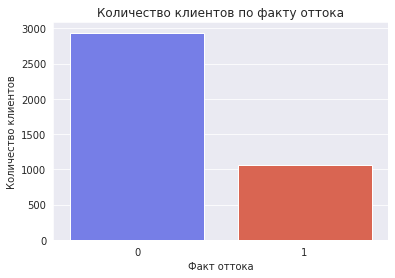

In [9]:
fivethirtyeight = [ '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
sns.set_palette(fivethirtyeight)
sns.set_style("darkgrid")
sns.countplot(x='churn', data=df)
plt.xlabel('Факт оттока')
plt.title('Количество клиентов по факту оттока')
plt.ylabel('Количество клиентов')
plt.show()

Наша выборка является несбалансированной. Клиентов, не вернувшихся офформить новый абонемент, меньше почти в три раза.

In [10]:
dict_label= {'gender':{'title': 'Количество клиентов и факт оттока по полу','xlabel':'Пол клиента'},
'near_location': {'title':'Количество клиентов проживающих рядом \n и факт оттока','xlabel':'Факт проживания или работы рядом'},
             'partner':{'title':'Количество клиентов-партнеров и факт оттока','xlabel':'Является ли клиентом-партнером'},
             'promo_friends':{'title':'Количество клиентов, пришедшие по акции \n и факт оттока ','xlabel':'Заключение первого договора в рамках акции'},
             'phone':{'title':'Количество клиентов с контактным телефоном \n и факт оттока','xlabel':'Наличие контактного телефона'},
'group_visits':{'title':'Количество клиентов, посещающих \n групповые занятия и факт оттока','xlabel':'Факт посещения групповых занятий'},
'contract_period':{'title':'Количество клиентов по длительности \n абонемента и факт оттока','xlabel':'Длительность текущего действующего абонемента в месяцах'}}

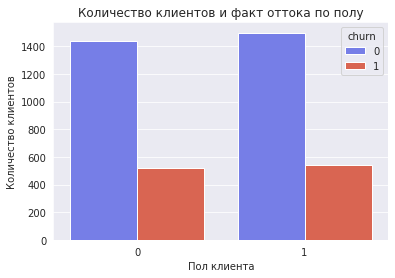

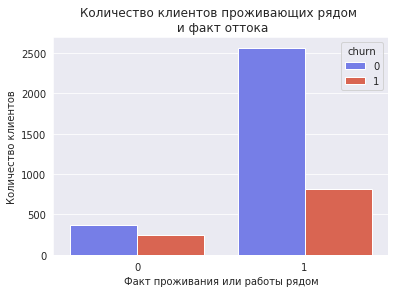

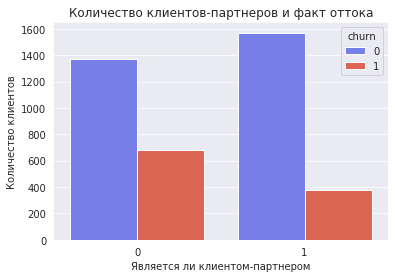

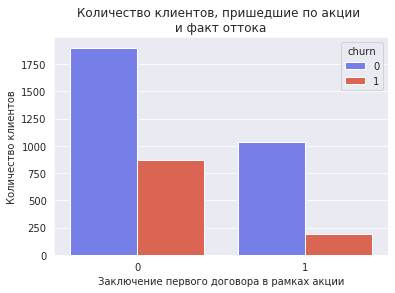

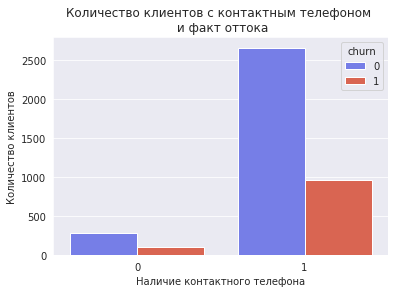

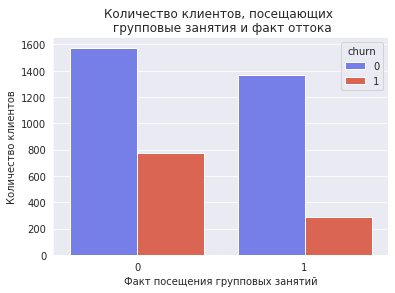

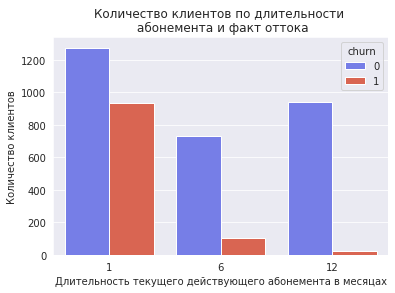

In [11]:

for key, value in dict_label.items():
    sns.countplot(hue='churn', x=key, data=df)
    plt.xlabel(value['xlabel'])
    plt.title(value['title'])
    plt.ylabel('Количество клиентов')
    plt.show()

Согласно графикам представленным выше можно сделать следующие выводы:

- наименьший отток среди клиентов, купивших годовой абонемент;
- клиенты, не проживающие или не работающие в районе клуба, уходят в большем количестве;
- мужчины и женщины в равной степени склонны к отказу от услуг центра.

В целом, графики категориальных признаков подтверждают выводы, сделанные на основе ранее проведенного анализа описательной статистики. Далее посмотрим на рспределения количественных признаков.

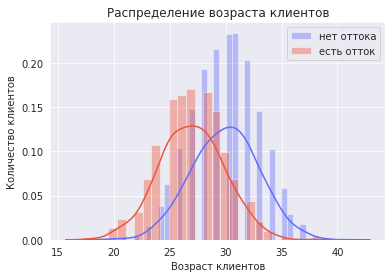

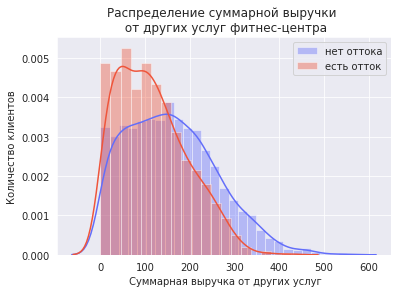

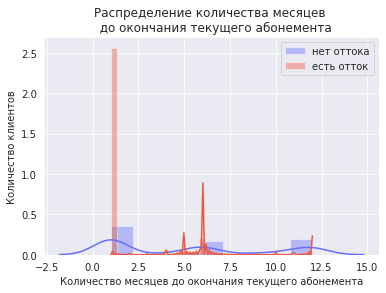

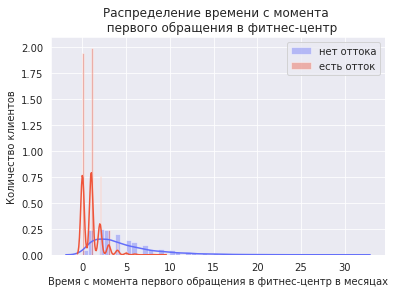

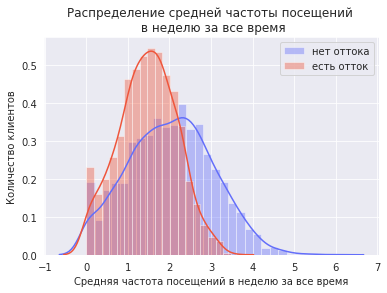

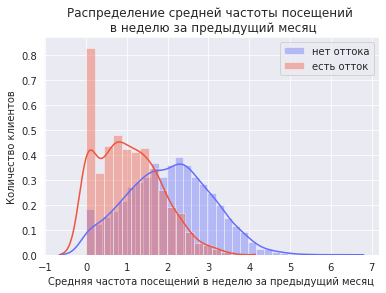

In [12]:
dict_label= {'age':{'title':'Распределение возраста клиентов','xlabel':'Возраст клиентов'},
       'avg_additional_charges_total':{'title':'Распределение суммарной выручки \n от других услуг фитнес-центра','xlabel':' Суммарная выручка от других услуг'}, 
       'month_to_end_contract':{'title':'Распределение количества месяцев \n  до окончания текущего абонемента','xlabel':'Количество месяцев до окончания текущего абонемента'},
             'lifetime':{'title':'Распределение времени с момента \n  первого обращения в фитнес-центр','xlabel':'Время с момента первого обращения в фитнес-центр в месяцах'},
       'avg_class_frequency_total':{'title':'Распределение средней частоты посещений \n в неделю за все время','xlabel':'Средняя частота посещений в неделю за все время'},
             'avg_class_frequency_current_month':{'title':'Распределение средней частоты посещений \n в неделю за предыдущий месяц','xlabel':'Средняя частота посещений в неделю за предыдущий месяц'},
            }

for key, value in dict_label.items():
    sns.distplot(df.query('churn==0')[key],kde=True, label="нет оттока")
    sns.distplot(df.query('churn==1')[key], kde=True, label="есть отток")
    plt.legend()
    plt.xlabel(value['xlabel'])
    plt.title(value['title'])
    plt.ylabel('Количество клиентов')
    plt.show()

Распределения некоторых количественных перменных сильно далеки от нормального распределения, а также отличается масштаб. При построении модели необходимо это будет учесть и провести стандартизацию признаков.

Построим корреляциооную матрицу для анализа связи целевой перемнной и признаков.

In [13]:
cm=df.corr()

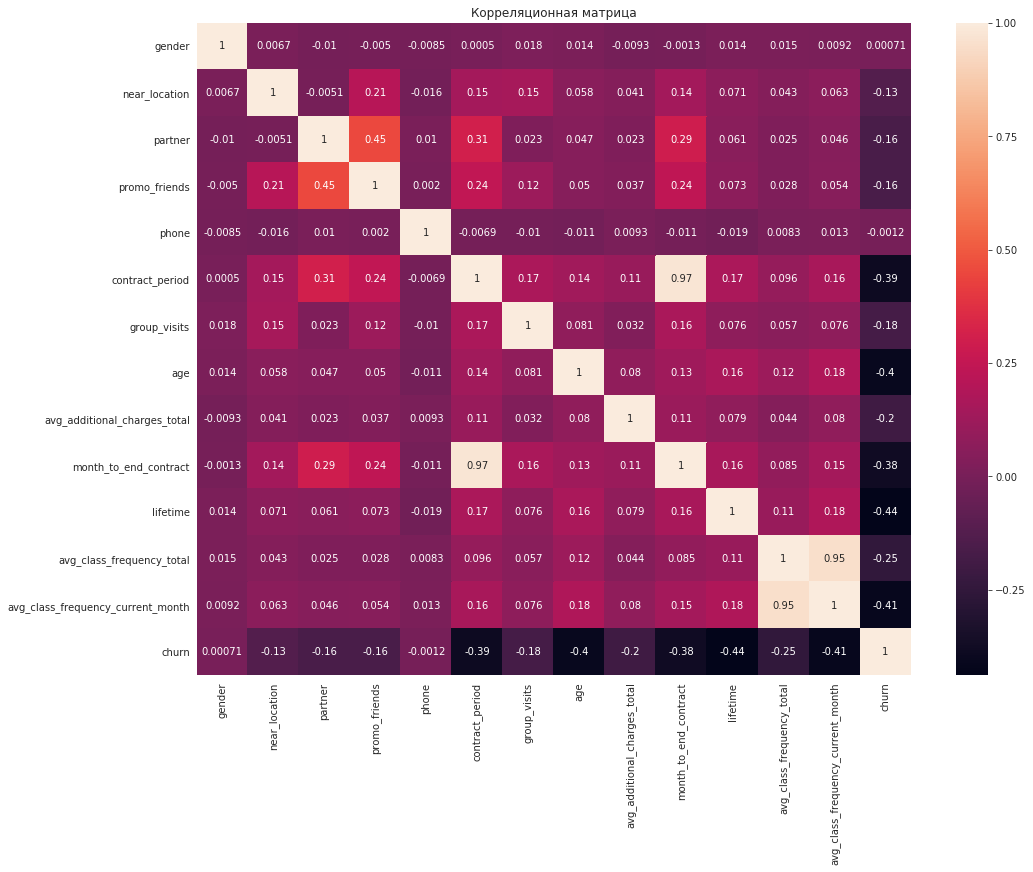

In [14]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(cm, annot = True)
plt.xticks(rotation=90)
plt.title('Корреляционная матрица')
plt.show()

Согласно матрице, мы видим, что наибольшее влияние на отток оказывают длительность абонемента, возраст, срок до окончания действующего абонемента, время с момента первого посещения фитнес-центра и средняя частота посещений в неделю за предыдущий месяц. С увеличением значений данных признаков, факт оттока клиентов будет менее вероятен.

При изучении корреляционной матрицы можно также заметить мультиколлинеарность у следующих пар признаков: 
- *month_to_end_contract* и *contract_period* (корреляция 0.97);
- *avg_class_frequency_total* и *avg_class_frequency_current_month* (корреляция 0.95).

При построении модели не можем включить все признаки, которые мультиколлинеарны, поскольку в  машинном обучении  мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату, полученные оценки параметров будут не надежны. Помимо этого, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки увеличивается. Для решения проблемы мультиколлинеарности оставим только один признак из каждой пары. Например, можно оставить признаки у которых больше корреляция с целевой переменной: *contract_period* и  *avg_class_frequency_current_month*.

Также не имеет смысл включать в модель признаки *gender* и *phone*, которые практически никак не коррелируют с оттоком клиентов.



### Выводы

В результате проведения исследовтельского анализа данных можно сделать следующие выводы:

* данные были хорощо подготовлены и выгружены: отсутствуют пропущенные значения и дублирующие строки, тип данных корректен;
* выборка является несбалансированной, что следует учесть при построении модели;
* при первичном анализе дескриптивной статистики было определено:

  - полловое соотношение среди клиентов почти равное
  - бОльшая часть клиентов проживает или работает в районе фитнес-центра
  - около 40% клиентов посещает групповые занятия
  - средний возраст клиентов составляет 29 лет
  - уровень оттока равен 26,5%
  
  
* при дальнейшем построении модели необходимо проведение стандартизации признаков;
* при изучении корреляционной матрицы, были выявлены признаки мультиколлинеарности, а также опредлены переменные, которые можно не включать в модель

## Построение модели прогнозирования оттока клиентов <a id="3."></a> 

[к содержанию](#0)

In [15]:
#из признаков исключаем целевую пременную и признаки, которые было решено не включать в модель
X = df.drop(columns=['churn', 'month_to_end_contract','avg_class_frequency_total','gender','phone'])
y = df['churn']

In [16]:
#заранее прописываем функцию для расчета метрик модели
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.3f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.3f}'.format(roc_auc_score(y_true, y_proba)))

In [17]:
#делим выборку обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


In [19]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0 )
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [21]:
#выведем метрики для логистической регрессии
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.901
	Precision: 0.790
	Recall: 0.818
	F1: 0.804
	ROC_AUC: 0.962


Доля правильных ответов в модели логистической регрессии составляет 90.1%. Доля правильных ответов среди уходящих клиентов составляет 79%, а среди остающихся в клубе - 81,8%. Однако, вспомним, что наша выборка является несбалансированной, а значит имеет место искажение метрик, которое можно скорректировать. 

Recall на уровне 82% – значит, среди всех ушедших клиентов (со значением churn=1) алгоритм верно распознал 82%, для остальных 18% алгоритм по ошибке выдал класс 0. 
    
Precision на уровне 79% – значит, среди клиентов с предсказанным классом 1 всего 79% действительно уходящих клиентов (со значением churn=1), остальные 21% клиентов на самом деле остались (churn=0).
    
Если мы по ошибке будем мотивировать клиента, который уходить не собирался, это не так критично, как если мы упустим клиента, покидающего клуб. Наша задача состоит в удержании клиентов. Поэтому в приоритете метрика recall. Значит порог следует сместить немного вниз.

In [22]:
# задаем порог
threshold = 0.4

# на основании вероятностей и соотношения классов рассчитайте predict
custom_predictions = [0 if i<threshold else 1 for i in lr_probabilities]

In [23]:
print_all_metrics(y_test, custom_predictions, lr_probabilities,  title='Метрики для модели логистической регрессии с кастомным порогом:')

Метрики для модели логистической регрессии с кастомным порогом:
	Accuracy: 0.905
	Precision: 0.775
	Recall: 0.869
	F1: 0.819
	ROC_AUC: 0.962


Метрики модели с кастомным порогом улучшились: доля правильных ответов повысилась до 90.5%, процент правильных ответов среди целевого класса клиентов стал равен 86.9%, ожидаемо снизился percision, однако F1 - мера, учитывающая баланс между percision и recall, незначительно повысилась, что может говорить, об улучшении качества модели. А площадьт кривой ошибок по-прежнему осталась на высоком уровне в 0.962, значении близкому к единице.

In [24]:
#выведем метрики для модели случайного леса
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')


Метрики для модели случайного леса:
	Accuracy: 0.889
	Precision: 0.791
	Recall: 0.747
	F1: 0.769
	ROC_AUC: 0.949


По аналогии зададим кастомный порог для модели случайного леса

In [25]:
# задаем порог
threshold = 0.4

# на основании вероятностей и соотношения классов рассчитайте predict
custom_predictions_rf = [0 if i<threshold else 1 for i in rf_probabilities]

In [26]:
print_all_metrics(y_test, custom_predictions_rf, rf_probabilities, title = 'Метрики для модели случайного леса c кастомным порогом:')

Метрики для модели случайного леса c кастомным порогом:
	Accuracy: 0.901
	Precision: 0.769
	Recall: 0.859
	F1: 0.811
	ROC_AUC: 0.949


Исходя из значений метрик модель логистической регрессии подходит больше, однако разница не между метриками не значительна. Возможно, для модели случайного леса можно найти более оптимальные параметры и тогда, она будет выигравать у логистической регрессии.

Попробуем провести оптимизацию гиперпараметров для модели случайного леса методом перекрестной провекри K-Fold Validation.

In [27]:
#определяем сетку гиперпармаетров, которые будут выбираться случайным образом
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}
clf = RandomForestClassifier(random_state=0) ### нужен random_state


In [28]:
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 20, 
                               cv=4, verbose= 5, random_state= 0, n_jobs = -1)

In [29]:
#обучаем модель
model.fit(X_train_st,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy, score=0.911, total=   1.4s
[CV] n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy, score=0.905, total=   1.4s
[CV] n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV]  n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy, score=0.912, total=   1.6s
[CV] n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s


[CV]  n_estimators=384, min_samples_split=7, min_samples_leaf=4, max_features=sqrt, max_depth=538, criterion=entropy, score=0.894, total=   1.5s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini, score=0.913, total=   6.3s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini 
[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini, score=0.900, total=   6.3s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini 
[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini, score=0.907, total=   6.4s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini 
[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=6, max_features=None, max_depth=671, criterion=gini, score=0.885, total=   6.5s
[CV] n_estimators=733, min_samples_split=5, min_samples_leaf=8, max_features

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.9min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [30]:
#вывод оптимально подобранных параметров
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=617,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
rf2_predictions = model.best_estimator_.predict(X_test_st)
rf2_probabilities = model.best_estimator_.predict_proba(X_test_st)[:,1]

In [32]:
print_all_metrics(y_test, rf2_predictions, rf2_probabilities, title = 'Метрики для модели случайного леса после оптимизации гиперпараметров:')

Метрики для модели случайного леса после оптимизации гиперпараметров:
	Accuracy: 0.904
	Precision: 0.817
	Recall: 0.788
	F1: 0.802
	ROC_AUC: 0.953


In [33]:
data={'metric':['Accuracy','Precision','Recall','F1','ROC_AUC'],
    'logistic':[accuracy_score(y_test, custom_predictions), precision_score(y_test, custom_predictions),recall_score(y_test, custom_predictions), f1_score(y_test, custom_predictions), roc_auc_score(y_test,lr_probabilities)], 
    'random_forest':[accuracy_score(y_test, custom_predictions_rf), precision_score(y_test, custom_predictions_rf),recall_score(y_test, custom_predictions_rf), f1_score(y_test, custom_predictions_rf), roc_auc_score(y_test,rf_probabilities)],
    'random_forest_opt': [accuracy_score(y_test, rf2_predictions), precision_score(y_test, rf2_predictions),recall_score(y_test, rf2_predictions), f1_score(y_test, rf2_predictions), roc_auc_score(y_test,rf2_probabilities)]}
data = pd.DataFrame(data) 
data                   

,metric,logistic,random_forest,random_forest_opt
0,Accuracy,0.905000,0.901250,0.903750
1,Precision,0.774775,0.769231,0.816754
2,Recall,0.868687,0.858586,0.787879
3,F1,0.819048,0.811456,0.802057
4,ROC_AUC,0.962163,0.948929,0.953388


После оптимизации гиперпараметров модели случайного леса, метрики улучшились. Однако, F1 и roc-auc по-прежнему выше у логистической модели. Возможно, при увеличении числа итераций при оптимизации гиперпараметров метрики модели случайного леса могли бы быть выше, чем у логистической модели, однако, даже при 20 итерациях процесс оптимизации занимает около 4 минут, что достаточно долго. Подобные затраты времени не стоят результа, поскольку метрики логистической модели и так говорят о достаточно высоком качестве модели. Построенная логистическая модель дает 90.9% правильных ответов.

In [34]:
#выведем коэффициенты логистической модели
coef=pd.DataFrame(zip(X_train.columns, np.transpose(lr_model.coef_.tolist()[0])), columns=['features', 'coef'])
display(coef.iloc[(-np.abs(coef['coef'].values)).argsort()])

,features,coef
7,lifetime,-3.793532
3,contract_period,-1.310302
8,avg_class_frequency_current_month,-1.305880
5,age,-1.082482
6,avg_additional_charges_total,-0.570730
4,group_visits,-0.370718
2,promo_friends,-0.243216
0,near_location,-0.080267
1,partner,-0.063474


Согласно полученным коэффициентам на уменьшение вероятности оттока больше всего влияет увеличение времени с момента первого обращения в фитнес-центр, длительности договора, средней частоты посещений в неделю. Также значительную роль в снижении оттока играет и увеличение возраста клиентов.

### Выводы

В процессе построения модели нами были рассмотрены два варианта - логистическая модель и модель случайного леса. Основываясь на анлизе метрик, в качестве оптимальной модели по предсказанию оттока клиентов нами была выбрана логистическая модель. Анализ коэффициентов показал, что наиболее важными признаками, влияющими на отток клиентов, можно назвать:

- время с момента первого обращения в фитнес-центр;
- длительность договора;
- средняя частота посещений в неделю;
- возраст клиента.

## Кластеризация клиентов <a id="4."></a> 

[к содержанию](#0)

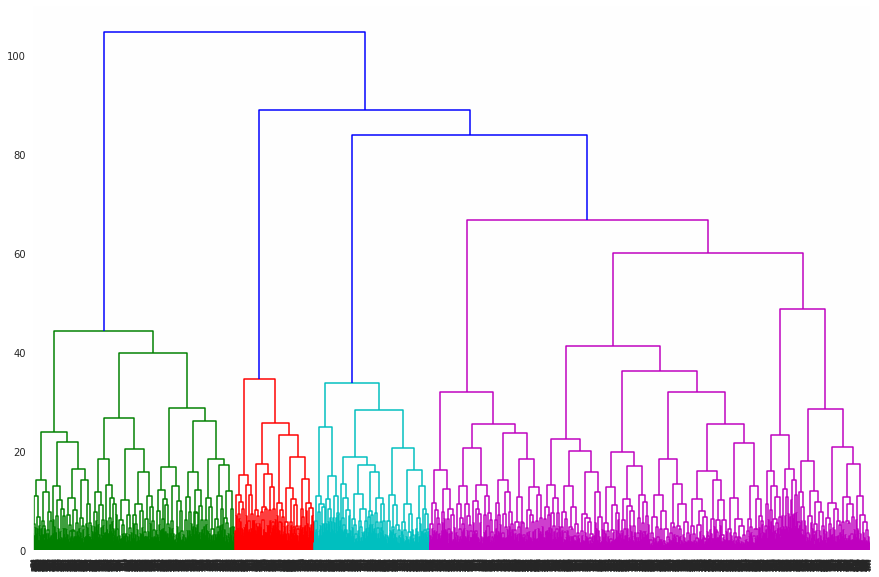

In [35]:
X = df.drop(columns=['churn']) 
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 


На основании полученного графика, можно выделить 4 кластера клиентов. Однако согласно нашему ТЗ необходимо описать 5 кластеров.

In [36]:
km = KMeans(n_clusters = 5, random_state=0) ### нужен random_state
labels = km.fit_predict(X_sc)

In [37]:
df['cluster']=labels

In [38]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


Будем наименовать кластеры согласно их номерам с 0 до 4.
В целом все кластеры сбалансированны по половому соотношению. Нулевой кластер больше чем на половину состоит из клиентов, которые пришли в клуб по акции "приведи друга". Клиенты первого кластера не оставили клубу свой номер телефона. Клиенты нулевого кластера заключают в основном годовые абонементы. Нулевой и четвертый кластеры являются самыми давними клиентами клуба. Средняя посещаемость в неделю выше всего у четвертого кластера. Для более детального изучения каждого кластера рассмотрим распределения признаков и проанализируем уровень оттока по кластерам.

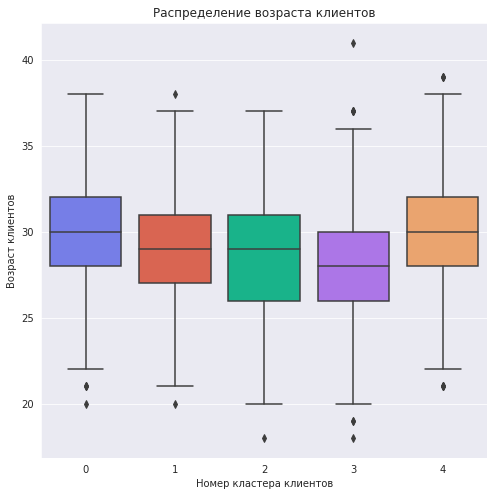

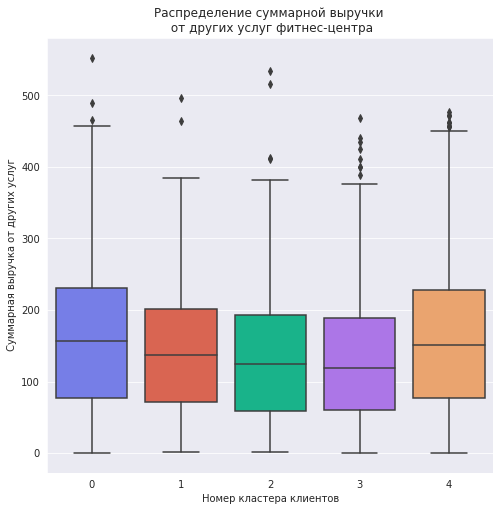

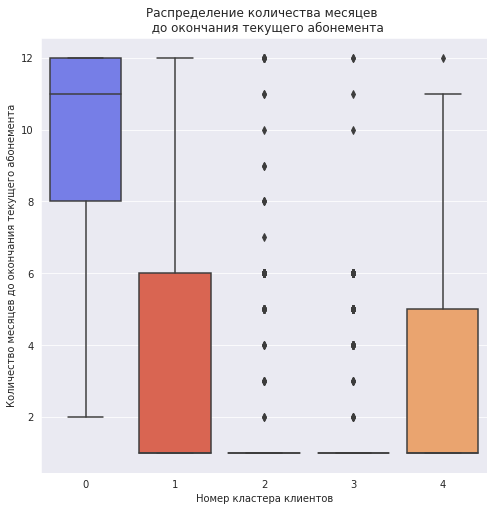

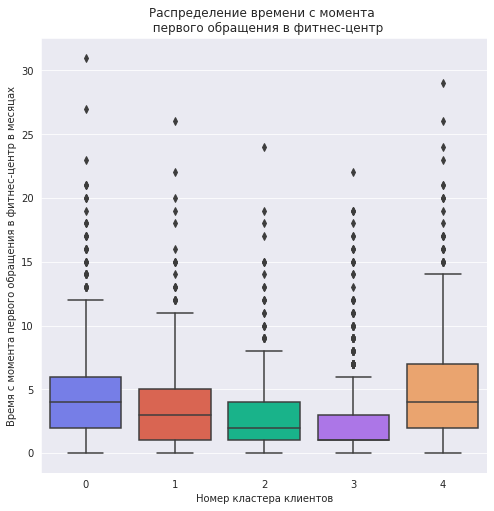

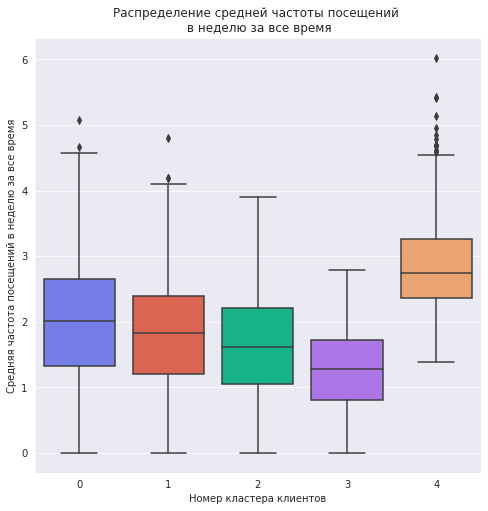

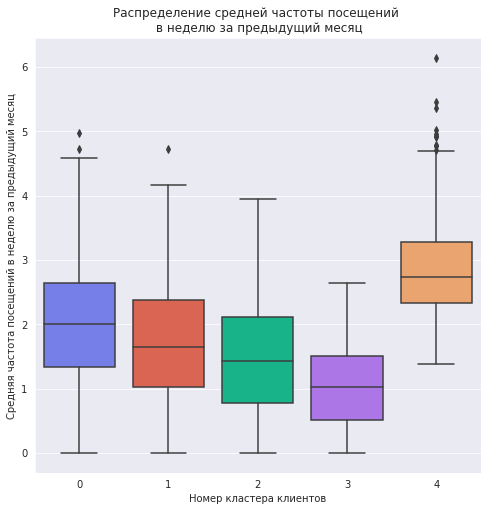

In [39]:
dict_label= {'age':{'title':'Распределение возраста клиентов','ylabel':'Возраст клиентов'},
       'avg_additional_charges_total':{'title':'Распределение суммарной выручки \n от других услуг фитнес-центра','ylabel':' Суммарная выручка от других услуг'}, 
       'month_to_end_contract':{'title':'Распределение количества месяцев \n  до окончания текущего абонемента','ylabel':'Количество месяцев до окончания текущего абонемента'},
             'lifetime':{'title':'Распределение времени с момента \n  первого обращения в фитнес-центр','ylabel':'Время с момента первого обращения в фитнес-центр в месяцах'},
       'avg_class_frequency_total':{'title':'Распределение средней частоты посещений \n в неделю за все время','ylabel':'Средняя частота посещений в неделю за все время'},
             'avg_class_frequency_current_month':{'title':'Распределение средней частоты посещений \n в неделю за предыдущий месяц','ylabel':'Средняя частота посещений в неделю за предыдущий месяц'},
            }

for key, value in dict_label.items():
    plt.figure(figsize=(8,8))
    ax = sns.boxplot(y=key, x='cluster', data=df)
    plt.xlabel('Номер кластера клиентов')
    plt.ylabel(value['ylabel'])
    plt.title(value['title'])
    plt.show()

In [40]:
dict_label= {'gender':{'title': 'Количество клиентов по полу','xlabel':'Пол клиента'},
'near_location': {'title':'Количество клиентов проживающих рядом','xlabel':'Факт проживания или работы рядом'},
             'partner':{'title':'Количество клиентов-партнеров и факт оттока','xlabel':'Является ли клиентом-партнером'},
             'promo_friends':{'title':'Количество клиентов, пришедшие по акции','xlabel':'Заключение первого договора в рамках акции'},
             'phone':{'title':'Количество клиентов с контактным телефоном','xlabel':'Наличие контактного телефона'},
'group_visits':{'title':'Количество клиентов, посещающих \n групповые занятия','xlabel':'Факт посещения групповых занятий'},
'contract_period':{'title':'Количество клиентов по длительности абонемента','xlabel':'Длительность текущего действующего абонемента в месяцах'}}

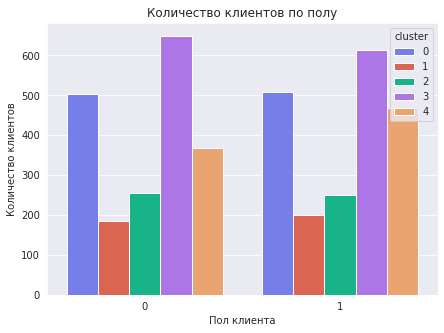

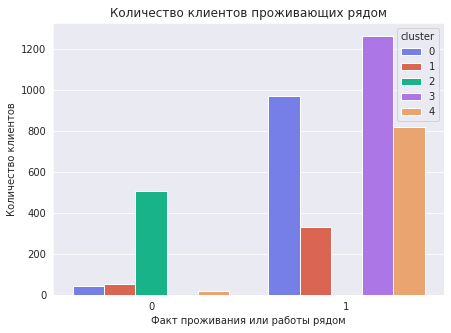

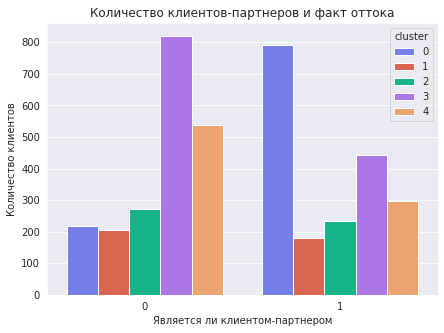

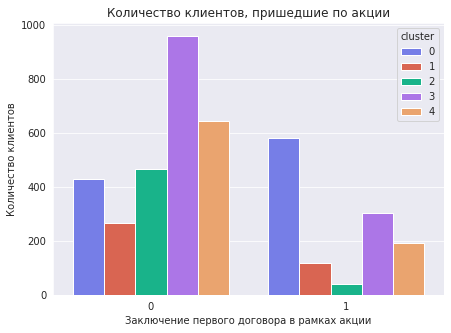

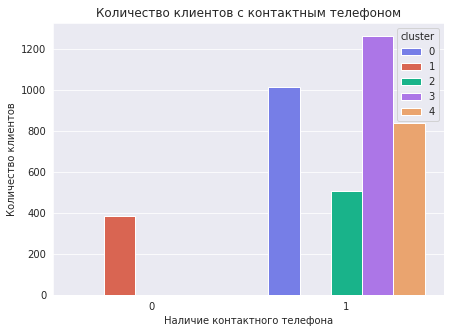

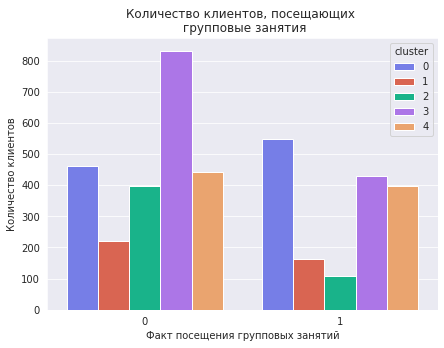

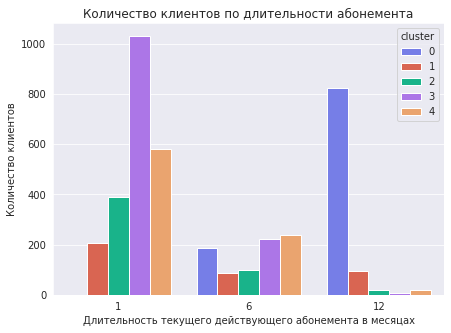

In [41]:
for key, value in dict_label.items():
    plt.figure(figsize=(7,5))
    sns.countplot(hue='cluster', x=key, data=df)
    plt.xlabel(value['xlabel'])
    plt.title(value['title'])
    plt.ylabel('Количество клиентов')
    plt.show()

In [42]:
df.groupby('cluster')['churn'].mean()

cluster
0    0.027695
1    0.267532
2    0.443564
3    0.514263
4    0.068100
Name: churn, dtype: float64

***кластер 0***:

- **уровень оттока 2.8%**;
- приобретение в основном годовых абонементов;
- одни из давних клиентов клуба в сравнении с другими кластерами;
- средняя частота посещений в неделю около 2 раз;
- в основном проживают или работают в районе с клубом;
- бОьшая часть клиентов является сотрудниками компании-партнера;
- больше половины посещает групповые занятия;

***кластер 1***:

- **уровень оттока 26.7%**;
- приобретение абонементов в основном на 1 месяц;
- клиенты не оставили контактного номера;
- в основном проживают или работают в районе с клубом;
- около половины клиентов является сотрудниками компании-партнера;
- в основном клиенты кластера пришли по акции "приведи друга";

***кластер 2***:

- **уровень оттока 44.4%**;
- средняя частота посещений в неделю 1 раз;
- приобретение абонементов в основном на 1 месяц;
- все клиенты не проживают или не работают в районе с клубом;
- бОльшая часть клиентов кластера пришли по акции "приведи друга";
- в основном не посещают групповые занятия;


***кластер 3***:

- **уровень оттока 51.4%**;
- средний возраст клиентов наиболее молодой в сравнении с остальными;
- самые новые клиенты клуба;
- средняя частота посещений в неделю 1 раз;
- приобретение абонементов в основном на 1 месяц;
- все клиенты проживают или работают в районе с клубом;
- бОльшая часть клиентов является сотрудниками компании-партнера;
- значительная часть клиентов кластера пришли по акции "приведи друга";
- в основном не посещают групповые занятия;

***кластер 4***:

- **уровень оттока 6.8%**;
- приобретение в основном месячных абонементов;
- на равне с кластером 0 одни из давних клиентов клуба;
- средняя частота посещений в неделю выше чем в остальных кластерах (более 2 раз);
- в основном проживают или работают в районе с клубом;
- бОьшая часть клиентов является сотрудниками компании-партнера;


Наибольший отток у кластера 3 и на это повлияли небольшие значения признаков, которые были обозначены наиболее важными по результатам анализа построенной модели предсказания оттока. Наименьший отток у кластера 0, у которого наоборот высокие значения длительности абонементов, времени с момента первого визита, средней частоты посещений в неделю.

## Общие выводы и рекомендации <a id="5."></a> 

[к содержанию](#0)

В резльтате работы нами были достигнуты следующие результаты:

* построена модель предсказания вероятности оттока клиентов с точностью предсказания 90.5%;


* проведена кластеризация клиентов и описан портрет каждого кластера;



* выявлены основные признаки влияющие на отток клиентов:
 - время с момента первого обращения в фитнес-центр;
 - длительность договора;
 - средняя частота посещений в неделю;
 - возраст клиента
 
 С увеличением значений данных признаков вероятность оттока будет снижаться.
    

Целевыми клиентами можно считать клиентов, которые уже довольно продолжительное время посещают фитнес-центр и приобретают годовые абонементы, которые активно посещают тренировки от 2 раз в неделю и более, также они должны проживатьили работать в районе клуба и могут являться сотрудниками компании-партнера.

Для снижения оттока можно рекомендовать следующее:
- привлекать более взрослых клиентов;
- увеличивать продажи годовых абонементов;
- стимулировать клиентов на более частое посещение клуба, возможно проведениями различных акций на подобии челеннджей и бонусными поощрениями.